# Imports

In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

# Load Data

In [2]:
# List all data available
datapath = r'../assets/'
# datapath = r'/kaggle/input/ga-dengue/assets'
os.listdir(datapath)

['text.md',
 'google_trend_fever.csv',
 'wolbachia_ratio.csv',
 'datagov_dengue.csv',
 '.ipynb_checkpoints',
 'google_trend_dengue.csv',
 'google_trend_dengue_symptoms.csv',
 'jao_dengue.csv',
 'NEA_weather.csv',
 'datagov_weather.csv',
 'google_trend_mosquito.csv',
 'datagov_RH.csv',
 'NEA_dengue.csv']

Loading all data for cleaning and compiling

In [3]:
# UPDATE CELL
# Dengue
df_dengue_datagov_raw = pd.read_csv(os.path.join(datapath,'datagov_dengue.csv'))
df_dengue_jao_raw = pd.read_csv(os.path.join(datapath,'jao_dengue.csv'))
df_dengue_NEA_raw = pd.read_csv(os.path.join(datapath,'NEA_dengue.csv'))

# Weather
df_weather_datagov_raw = pd.read_csv(os.path.join(datapath,'datagov_weather.csv'))
df_weather_NEA_raw = pd.read_csv(os.path.join(datapath,'NEA_weather.csv'))
df_weather_datagov_RH_raw = pd.read_csv(os.path.join(datapath,'datagov_RH.csv'))

# Google trend
df_trend_dengue_raw = pd.read_csv(os.path.join(datapath,'google_trend_dengue.csv'))
df_trend_dengue_symptoms_raw = pd.read_csv(os.path.join(datapath,'google_trend_dengue_symptoms.csv'))
df_trend_fever_raw = pd.read_csv(os.path.join(datapath,'google_trend_fever.csv'))
df_trend_mosquito_raw = pd.read_csv(os.path.join(datapath,'google_trend_mosquito.csv'))

# Wolbachia
df_wolbachia_raw = pd.read_csv(os.path.join(datapath,'wolbachia_ratio.csv'))

We first clean and compile the available __dengue__ data. Most years have 52 or 53 weeks, while 2024 only has 27 weeks so far. 2019 has some missing entries which will require some imputation later.

In [4]:
# Clean and compile dengue data
df_dengue_datagov = df_dengue_datagov_raw.copy()
df_dengue_datagov.rename(columns={'year':'Year','eweek':'Week','number':'Dengue_Count'}, inplace=True)    # Rename columns for consistency
df_dengue_datagov = df_dengue_datagov.groupby(['Year','Week']).sum()                                      # Combine normal dengue cases and hemorrhagic cases
df_dengue_datagov = df_dengue_datagov.drop(columns='type_dengue').reset_index()                           # Drop dengue fever type

df_dengue_jao = df_dengue_jao_raw.copy()
df_dengue_jao.rename(columns={'Week No.':'Week', 'Dengue (Count)':'Dengue_Count'},inplace=True)           # Rename columns for consistency
df_dengue_jao.drop(columns=['Daily Rainfall Total (mm)','Mean Temperature (C)'],inplace=True)

df_dengue_NEA = df_dengue_NEA_raw.copy()
df_dengue_NEA = df_dengue_NEA.reset_index()
df_dengue_NEA.drop(columns='Unnamed: 0',inplace=True)
df_dengue_NEA = pd.melt(df_dengue_NEA, id_vars=['index','week'],
                        value_vars=['2020','2021','2022','2023','2024'],
                        var_name='Year', value_name='Dengue_Count')                                       # Gathering into long format for consistency
df_dengue_NEA.drop(columns=['index'],inplace=True)
df_dengue_NEA.rename(columns={'week':'Week'},inplace=True)                                                # Rename columns for consistency

df_dengue = pd.concat([df_dengue_datagov,df_dengue_NEA,df_dengue_jao],axis=0)                             # Compiling all dengue datasets into single dataframe
df_dengue.dropna(inplace=True)                                                                            # Dropping small number of missing values
df_dengue = df_dengue.astype({'Year':'int', 'Dengue_Count':'int'})                                        # Converting to standard dtypes
df_dengue.drop_duplicates(subset=['Year','Week'],inplace=True)                                            # Dropping duplicate entries from different data sources
df_dengue.sort_values(by=['Year','Week'],inplace=True)                                                    # Sort in chronological order
df_dengue.groupby(['Year']).count()

,Week,Dengue_Count
Year,,
2012,52,52
2013,52,52
2014,53,53
2015,53,53
2016,53,53
2017,53,53
2018,53,53
2019,47,47
2020,53,53


Next, we clean and compile the __weather__ data. On further inpection, we see that the datagov data consists of weather information for years from 2009 to 2017 only.

In [5]:
# Show data structure and date range
df_weather_datagov = df_weather_datagov_raw.copy()
display(df_weather_datagov.head(5))
pd.to_datetime(df_weather_datagov['date']).min(), pd.to_datetime(df_weather_datagov['date']).max()

,date,station,daily_rainfall_total,highest_30_min_rainfall,highest_60_min_rainfall,highest_120_min_rainfall,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed
0,2009-01-01,Admiralty,na,na,na,na,na,na,na,na,na
1,2009-01-02,Admiralty,na,na,na,na,na,na,na,na,na
2,2009-01-03,Admiralty,na,na,na,na,na,na,na,na,na
3,2009-01-04,Admiralty,na,na,na,na,na,na,na,na,na
4,2009-01-05,Admiralty,na,na,na,na,na,na,na,na,na


(Timestamp('2009-01-01 00:00:00'), Timestamp('2017-11-30 00:00:00'))

Since we need data from 2012 to 2024, we will not use the datagov weather data. We will focus on NEA weather instead, which has been scraped from NEA for the required date range. Missing data has been encoded as -1 in this dataset. As shown, the NEA dataset contains daily weather information information from multiple weather stations.

In [6]:
df_weather_NEA = df_weather_NEA_raw.copy()
df_weather_NEA.sample(5)

,Unnamed: 0,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
7965,27,Upper Thomson,2015,12,28,8.6,8.2,8.4,8.4,-1.0,-1.0,-1.0,-1.0,-1.0
246129,22,Buangkok,2012,7,23,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
16773,8,Bukit Panjang,2017,2,9,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
165971,18,Whampoa,2016,12,19,1.6,1.0,1.2,1.2,-1.0,-1.0,-1.0,-1.0,-1.0
164944,29,Choa Chu Kang (Central),2016,9,30,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0


Our dengue dataset provides weekly dengue counts for the whole of Singapore. To match the dengue dataset, we take the mean values for the different weather conditions across different weather stations and over the week. We see that the highest rainfall columns consists of more than 100 missing values. These columns are dropped here for simplicity.

In [7]:
df_weather_NEA.columns

Index(['Unnamed: 0', 'Station', 'Year', 'Month', 'Day',
       'Daily Rainfall Total (mm)', 'Highest 30 min Rainfall (mm)',
       'Highest 60 min Rainfall (mm)', 'Highest 120 min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)'],
      dtype='object')

In [8]:
# UPDATE CELL
# Get week of year
df_weather_NEA = df_weather_NEA.replace(-1, np.nan)                                     # Encode missing values as NaN
df_weather_NEA.drop(columns=['Unnamed: 0'],inplace=True)                                # Drop index column
df_weather_NEA.dropna(subset=['Year','Month','Day'],inplace=True)                       # Dropping records where the date in missing
df_weather_NEA = df_weather_NEA.astype({'Year':'int','Month':'int','Day':'int'})        # Convert to date time and extract week of year
df_weather_NEA['date'] = pd.to_datetime(df_weather_NEA[['Year', 'Month', 'Day']])
df_weather_NEA['Week'] = df_weather_NEA['date'].dt.isocalendar().week
df_weather_NEA.drop(columns=['Day','date','Station'],inplace=True)                      # Drop obsolete columns

# Renaming columns for convenience.
df_weather_NEA.rename(columns={'Daily Rainfall Total (mm)':'Daily_Rainfall',
                               'Highest 30 min Rainfall (mm)':'Highest_30mm_Rain',
                               'Highest 60 min Rainfall (mm)':'Highest_60mm_Rain',
                               'Highest 120 min Rainfall (mm)':'Highest_120mm_Rain',
                               'Mean Temperature (°C)':'Mean_Temperature',
                               'Maximum Temperature (°C)':'Max_Temperature',
                               'Minimum Temperature (°C)':'Min_Temperature',
                               'Mean Wind Speed (km/h)':'Min_Wind_Speed',
                               'Max Wind Speed (km/h)':'Max_Wind_speed'},inplace=True)

# Taking mean values over all stations and over all days of a given week
df_weather_NEA = df_weather_NEA.groupby(['Year','Month','Week']).mean()

# Check for missing values and drop highest 30mm, 60mm and 120mm rainfall columns.
print(df_weather_NEA.info())
df_weather_NEA.drop(columns=[col for col in df_weather_NEA if ('Highest' in col)], inplace=True)
df_weather_NEA = df_weather_NEA.reset_index()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 781 entries, (2012, 1, 1) to (2024, 6, 26)
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Daily_Rainfall      781 non-null    float64
 1   Highest_30mm_Rain   655 non-null    float64
 2   Highest_60mm_Rain   655 non-null    float64
 3   Highest_120mm_Rain  655 non-null    float64
 4   Mean_Temperature    781 non-null    float64
 5   Max_Temperature     781 non-null    float64
 6   Min_Temperature     781 non-null    float64
 7   Min_Wind_Speed      781 non-null    float64
 8   Max_Wind_speed      781 non-null    float64
dtypes: float64(9)
memory usage: 57.8 KB
None


UPDATE CELL
As humidity is known to be correlated with dengue fever but not provided by the NEA source, we additionally look at relative humidity data from a separate datagov dataset.

In [9]:
# UPDATE CELL
# Get relative humidity dataframe
df_RH_datagov = df_weather_datagov_RH_raw.copy()
df_RH_datagov['Year'] = pd.to_datetime(df_weather_datagov_RH_raw.month).dt.year
df_RH_datagov['Month'] = pd.to_datetime(df_weather_datagov_RH_raw.month).dt.month
df_RH_datagov.drop(columns=['month'],inplace=True)
df_RH_datagov.rename(columns={'mean_rh':'Relative_Humidity'},inplace=True)

# Merge relative humidity data into other weather data
df_weather = df_weather_NEA.merge(df_RH_datagov,on=['Year','Month'],how='left')

The final dataframe to be used as weather input is as shown below.

In [10]:
df_weather.sample(5)

,Year,Month,Week,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Relative_Humidity
366,2017,11,44,5.922711,27.790789,31.717073,24.812195,6.783871,33.555914,86.3
255,2016,1,53,9.947647,26.211667,27.990000,24.400000,7.458333,34.603333,79.6
616,2021,11,45,9.579560,27.330631,30.886441,24.416949,8.190090,36.349153,81.7
158,2014,7,27,5.777011,28.437719,31.299123,25.800000,6.679825,31.968421,78.3
645,2022,4,17,5.707168,28.474510,32.864706,25.799020,5.509804,28.460784,80.0


Next, __google search trends__ regarding dengue may indicate imminent occurence of dengue clusters. Specifically, we include search trends related to the keywords "dengue", "dengue+symptoms", "fever", and "mosquito".

In [11]:
# Renaming columns
df_trend_dengue = df_trend_dengue_raw.copy()
df_trend_dengue_symptoms = df_trend_dengue_symptoms_raw.copy()
df_trend_fever = df_trend_fever_raw.copy()
df_trend_mosquito = df_trend_mosquito_raw.copy()

df_trend_dengue.rename(columns={'dengue: (Singapore)':'Trend_Dengue'},inplace=True)
df_trend_dengue_symptoms.rename(columns={'dengue symptoms: (Singapore)':'Trend_Dengue_Symptoms'},inplace=True)
df_trend_fever.rename(columns={'fever: (Singapore)':'Trend_Fever'},inplace=True)
df_trend_mosquito.rename(columns={'mosquito: (Singapore)':'Trend_Mosquito'},inplace=True)

# Get week and year
df_trend_dengue['Year'] = pd.to_datetime(df_trend_dengue['Week']).dt.isocalendar().year
df_trend_dengue['Week'] = pd.to_datetime(df_trend_dengue['Week']).dt.isocalendar().week
df_trend_dengue_symptoms['Year'] = pd.to_datetime(df_trend_dengue_symptoms['Week']).dt.isocalendar().year
df_trend_dengue_symptoms['Week'] = pd.to_datetime(df_trend_dengue_symptoms['Week']).dt.isocalendar().week
df_trend_fever['Year'] = pd.to_datetime(df_trend_fever['Week']).dt.isocalendar().year
df_trend_fever['Week'] = pd.to_datetime(df_trend_fever['Week']).dt.isocalendar().week
df_trend_mosquito['Year'] = pd.to_datetime(df_trend_mosquito['Week']).dt.isocalendar().year
df_trend_mosquito['Week'] = pd.to_datetime(df_trend_mosquito['Week']).dt.isocalendar().week


# Combining into one dataframe
df_trends = df_trend_dengue.merge(df_trend_dengue_symptoms,how='left',on=['Week','Year'])
df_trends = df_trends.merge(df_trend_fever,how='left',on=['Week','Year'])
df_trends = df_trends.merge(df_trend_mosquito,how='left',on=['Week','Year'])
df_trends.drop_duplicates(subset=['Year','Week'],inplace=True) # Drop small number of repeated entries
df_trends

,Week,Trend_Dengue,Year,Trend_Dengue_Symptoms,Trend_Fever,Trend_Mosquito
0,52,51,2014,58,72,58
8,1,51,2015,74,71,71
9,2,51,2015,66,74,59
10,3,49,2015,60,69,59
11,4,62,2015,62,70,68
...,...,...,...,...,...,...
800,24,63,2024,59,82,88
801,25,63,2024,77,78,95
802,26,58,2024,76,85,81
803,27,57,2024,73,94,88


External, non-weather events may directly influence dengue incidence. For example, __Project Wolbachia__ to curb dengue spread may have reduced dengue cases, while __Covid-19 restrictions and increased construction activities__ after restrictions are lifted may have caused a rise in cases. Here, we consider Wolbachia efforts as the numerical feature `Wolbachia` given by the percentage of Singapore districts with Wolbachia release. On the other hand, COVID-19 restriction and high construction activity periods are encoded as a categorical feature `External_Events`.

In [12]:
df_wolbachia = df_wolbachia_raw.drop(columns=['Wolbachia_Areas'])
df_wolbachia.sample(5)

,Year,Week,Wolbachia_Ratio
354,2018,39,0.036364
27,2012,28,0.000000
170,2015,14,0.000000
268,2017,6,0.036364
120,2014,17,0.000000


In [13]:
df_external_events = df_wolbachia[['Year','Week']]
df_external_events['External_Events'] = 0
df_external_events.loc[(df_external_events.Year==2020) & (df_external_events.Week>=15) & (df_external_events.Week<=30),'External_Events'] = 1       # Period of high COVID restrictions, start of lockdown: 7th April 2020, end of phase 2: 17th July
# df_external_events.loc[(df_external_events.Year==2020) & (df_external_events.Week>=15),'External_Events'] = 1                                       # Period of high COVID restrictions, start of lockdown: 7th April 2020, start of phase 3: 28 Dec 2020
df_external_events.loc[(df_external_events.Year==2022) & (df_external_events.Week>=10) & (df_external_events.Week<=40),'External_Events'] = 1       # Period of increased construction activity in 2022 between weeks 10 and 40

We combined all data we have into a single dataframe. Visualizing missing data, we see that most of them are due to consideration of a 53rd week of the year. As mentioned earlier, some weeks in 2019 are missing dengue fever counts. Here, we:
1. drop 53rd week from each year
2. fill the missing values with `.ffill` methods.

In [14]:
df_raw = df_dengue.merge(df_weather,on=['Year','Week'],how='outer').merge(df_trends,on=['Year','Week'],how='outer')
df_raw = df_raw.merge(df_wolbachia,on=['Year','Week'],how='left')
df_raw = df_raw.merge(df_external_events,on=['Year','Week'],how='left')
display(df_raw[df_raw.isna().any(axis=1)])   # Show rows with missing values

,Year,Week,Dengue_Count,Month,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Relative_Humidity,Trend_Dengue,Trend_Dengue_Symptoms,Trend_Fever,Trend_Mosquito,Wolbachia_Ratio,External_Events
0,2011,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,72.0,87.0,68.0,NaN,NaN
189,2014,53,158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
314,2016,53,0.0,1.0,9.947647,26.211667,27.990000,24.400000,7.458333,34.603333,79.6,NaN,NaN,NaN,NaN,0.036364,0.0
378,2017,53,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036364,0.0
442,2018,53,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036364,0.0
499,2019,48,NaN,11.0,14.241613,27.601087,32.468041,25.008247,7.920952,33.560952,79.2,40.0,39.0,76.0,72.0,0.036364,0.0
500,2019,48,NaN,12.0,8.107843,28.053333,33.181250,25.450000,7.182353,30.152941,83.9,40.0,39.0,76.0,72.0,0.036364,0.0
501,2019,49,NaN,12.0,6.549143,27.418868,30.736036,25.310811,11.496610,39.640678,83.9,40.0,40.0,76.0,67.0,0.036364,0.0
502,2019,50,NaN,12.0,27.321003,25.009091,27.382692,23.375000,9.198214,32.920536,83.9,39.0,35.0,88.0,70.0,0.036364,0.0
503,2019,51,NaN,12.0,5.785920,26.448889,30.261458,24.387500,8.639167,30.013333,83.9,43.0,57.0,95.0,68.0,0.036364,0.0


In [15]:
# Final touches
df_raw = df_raw.loc[df_raw['Week']!=53]                           # Drop all week 53s
df_raw.ffill(inplace=True)                                        # Fill missing values
df_raw.dropna(inplace=True)                                       # Remove straggling row with missing values
df_raw = df_raw.astype({'Week':'int','Year':'int'})               # Ensure clean datatypes

# Exploratory Data Analysis (EDA)

In [16]:
# Create copy of main dataframe and show structure
df_plot = df_raw.copy()
df_plot.sample(5)

,Year,Week,Dengue_Count,Month,Daily_Rainfall,Mean_Temperature,Max_Temperature,Min_Temperature,Min_Wind_Speed,Max_Wind_speed,Relative_Humidity,Trend_Dengue,Trend_Dengue_Symptoms,Trend_Fever,Trend_Mosquito,Wolbachia_Ratio,External_Events
726,2023,30,199.0,7.0,0.548065,29.535455,32.607273,27.535455,10.051282,31.663248,75.1,65.0,73.0,75.0,94.0,0.272727,0.0
678,2022,42,369.0,10.0,8.168139,27.807143,31.399107,25.017857,6.483761,26.988034,78.7,35.0,52.0,75.0,63.0,0.272727,0.0
707,2023,13,127.0,4.0,8.906818,27.509375,31.984375,25.112500,6.012500,27.269697,77.4,57.0,77.0,87.0,84.0,0.272727,0.0
201,2015,10,110.0,3.0,2.559611,27.905000,32.745714,25.006429,8.452143,30.752143,75.8,55.0,34.0,77.0,72.0,0.000000,0.0
687,2022,49,335.0,12.0,13.360317,26.509244,30.112389,24.262832,6.341176,28.515833,81.2,27.0,28.0,65.0,62.0,0.272727,0.0


In [17]:
# Confirm that there are no missing values.
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 779 entries, 1 to 787
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   779 non-null    int64  
 1   Week                   779 non-null    int64  
 2   Dengue_Count           779 non-null    float64
 3   Month                  779 non-null    float64
 4   Daily_Rainfall         779 non-null    float64
 5   Mean_Temperature       779 non-null    float64
 6   Max_Temperature        779 non-null    float64
 7   Min_Temperature        779 non-null    float64
 8   Min_Wind_Speed         779 non-null    float64
 9   Max_Wind_speed         779 non-null    float64
 10  Relative_Humidity      779 non-null    float64
 11  Trend_Dengue           779 non-null    float64
 12  Trend_Dengue_Symptoms  779 non-null    float64
 13  Trend_Fever            779 non-null    float64
 14  Trend_Mosquito         779 non-null    float64
 15  Wolbachia_R

First, we look into the trends of dengue fever over the years. As shown, most years show a peak in the middle of the year, with years 2019, 2020 and 2022 showing higher than usual dengue fever cases, possibly related to Covid related lockdown. Year 2023 again shows lower dengue fever cases as lockdown restrictions are lifted. A peculiar case of low cases is shown for year 2021.

<Axes: xlabel='Week', ylabel='Dengue_Count'>

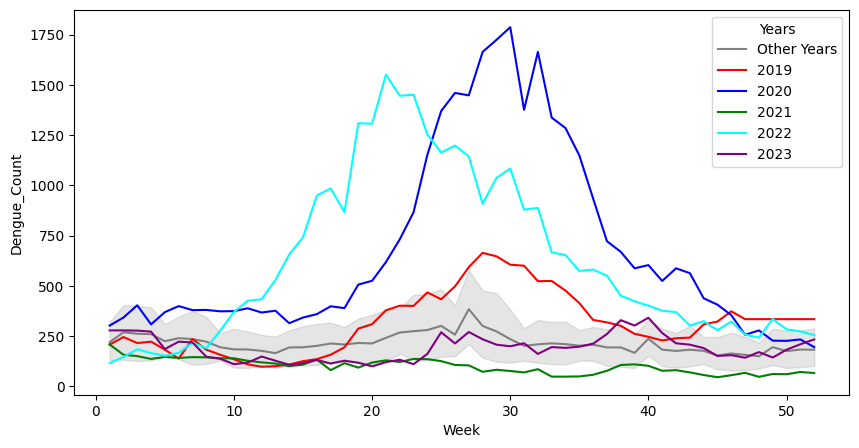

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
key_years = [2019,2020,2021,2022,2023]
df_plot['Years'] = df_plot['Year'].apply(lambda x: str(x) if x in key_years else 'Other Years')
palette = {'Other Years': 'gray', '2019': 'red', '2020':'blue','2021':'green','2022':'cyan','2023':'purple'}
sns.lineplot(data=df_plot, x='Week', y='Dengue_Count', hue='Years', palette=palette, legend=True,ax=ax)

We look at typical variation in dengue cases over a year.

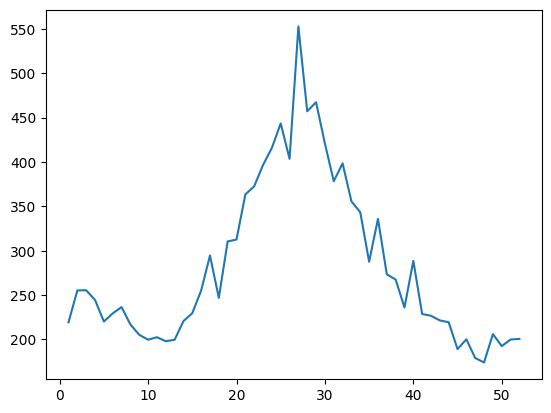

In [19]:
plt.plot(df_plot[['Week', 'Dengue_Count']].groupby('Week').mean())

Using a heatmap of linear correlation, we look at the relationship between dengue cases and the different temperature conditions. We see some correlation with temperature and relative humidity. However, linear relationships may not fully capture the complexity of dengue incidence in response to weather changes. In particular, dengue cases may be related to past weather conditions, as an Aedes egg can take 7 to 10 days to hatch and develop into an adult mosquito. Such relationships can be more properly explored in via statistical modelling.

<Axes: >

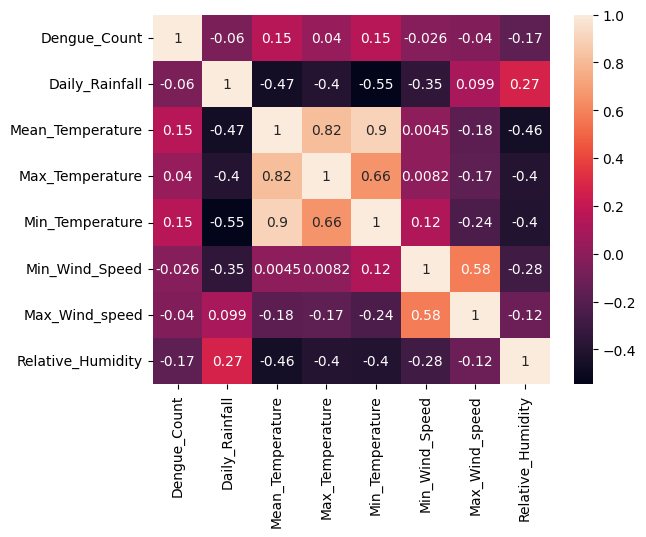

In [20]:
sns.heatmap(df_plot[['Dengue_Count','Daily_Rainfall', 'Mean_Temperature',
       'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
       'Max_Wind_speed','Relative_Humidity']].corr(),annot=True)

Finally, we see if there is a relationship between google search trends on Dengue and incidence of Dengue fever. As shown, there is a strong correlation between search for Dengue symptoms and Dengue fever incidence.

<Axes: >

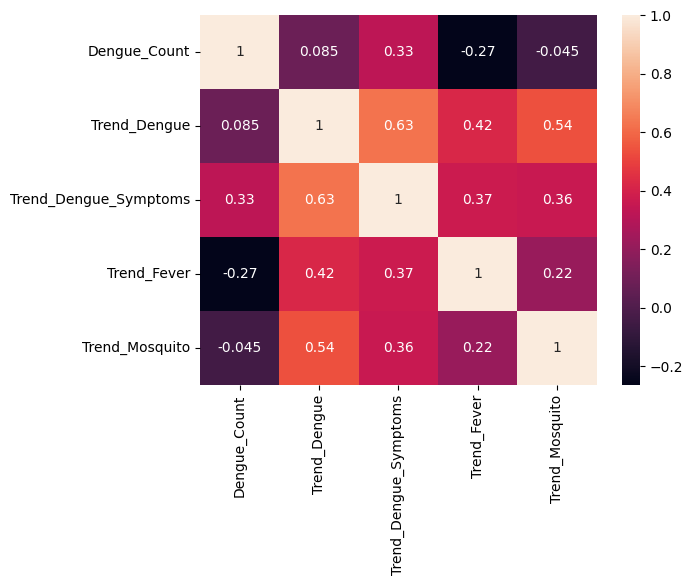

In [21]:
sns.heatmap(df_plot[['Dengue_Count','Trend_Dengue', 'Trend_Dengue_Symptoms','Trend_Fever','Trend_Mosquito']].corr(),annot=True)

Finally, we look at the effect of external events with similar plot, showing a strong correlation with external events.

<Axes: >

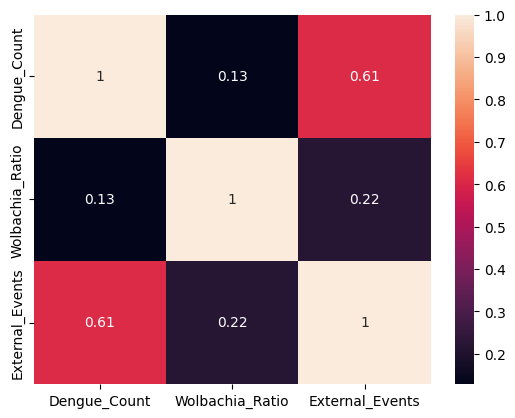

In [22]:
sns.heatmap(df_plot[['Dengue_Count','Wolbachia_Ratio', 'External_Events']].corr(),annot=True)

# Modelling

## Gradient Boosted Machines (GBM) - XGBoost

### Simple First Model

We use the XGBoost model here to forecast the occurence of Dengue Fever. To do this, we need to make use of past feature values. Here, we consider a lag of 5 weeks for all features and create a model to predict dengue cases one week in the future.

In [23]:
# Make feature dataset with lagged values.
df_xgb = df_raw.copy().drop(columns=['Wolbachia_Ratio', 'External_Events'])

lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms', 'Trend_Fever', 'Trend_Mosquito']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb['Dengue_Count']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=42)

Root mean Squared Error: 159.08550626574737


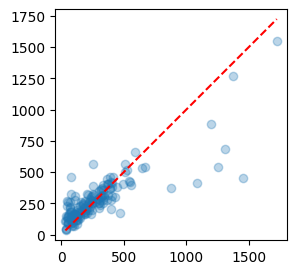

In [24]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean Squared Error: {rmse}")

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_test,y_pred,alpha=0.3)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
ax.axis('equal');

Feature importance plot shows that google search results are highly predictive of dengue fever occurences.

<BarContainer object of 68 artists>

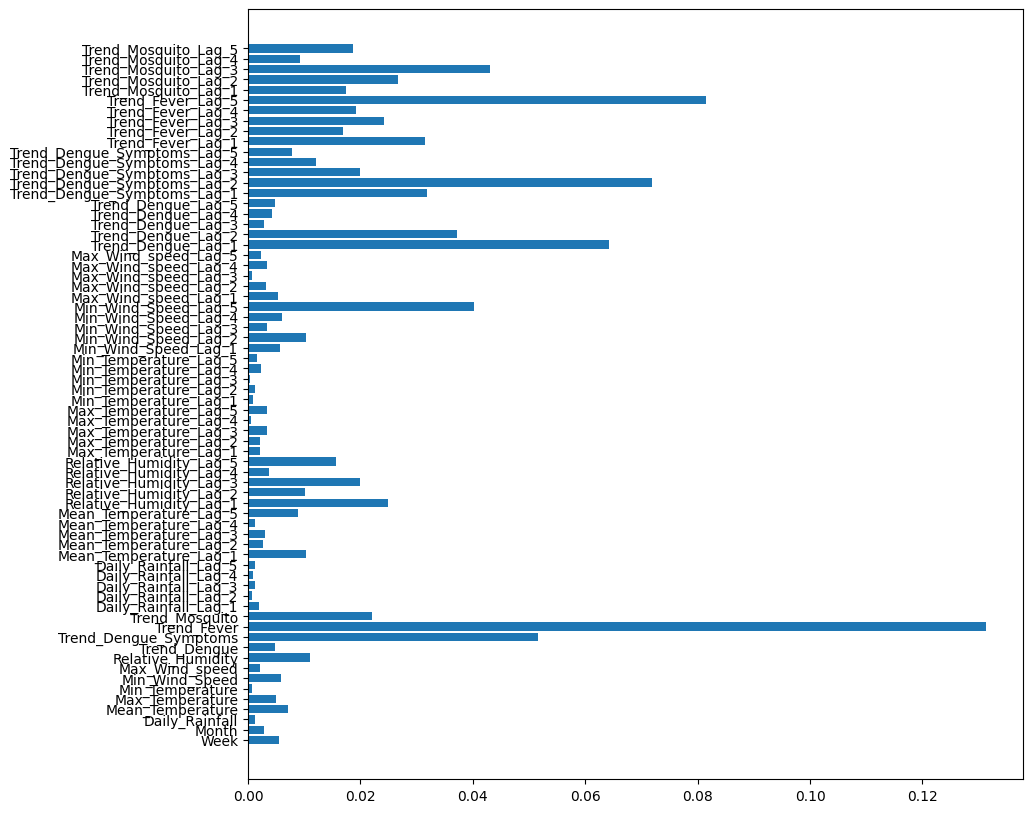

In [25]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.barh(X_train.columns,model.feature_importances_)

### Add events

The effect of dengue is dependent not just on prevailing weather conditions, but on external events, such as dengue control measures like the Wolbachia project or lockdown. We add these features into the existing data here.

In [26]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito', 'Wolbachia_Ratio', 'External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)
df_xgb.head()

# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=42)

Feature importance plot shows that covid restrictions heavily affects dengue cases, with Wolbachia project having minimum impact. Dengue related search trends remain highly predictive.

Root mean Squared Error: 74.76628321870032


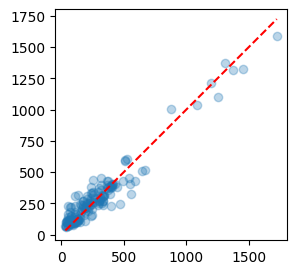

In [27]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean Squared Error: {rmse}")

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_test,y_pred,alpha=0.3)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
ax.axis('equal');

<BarContainer object of 80 artists>

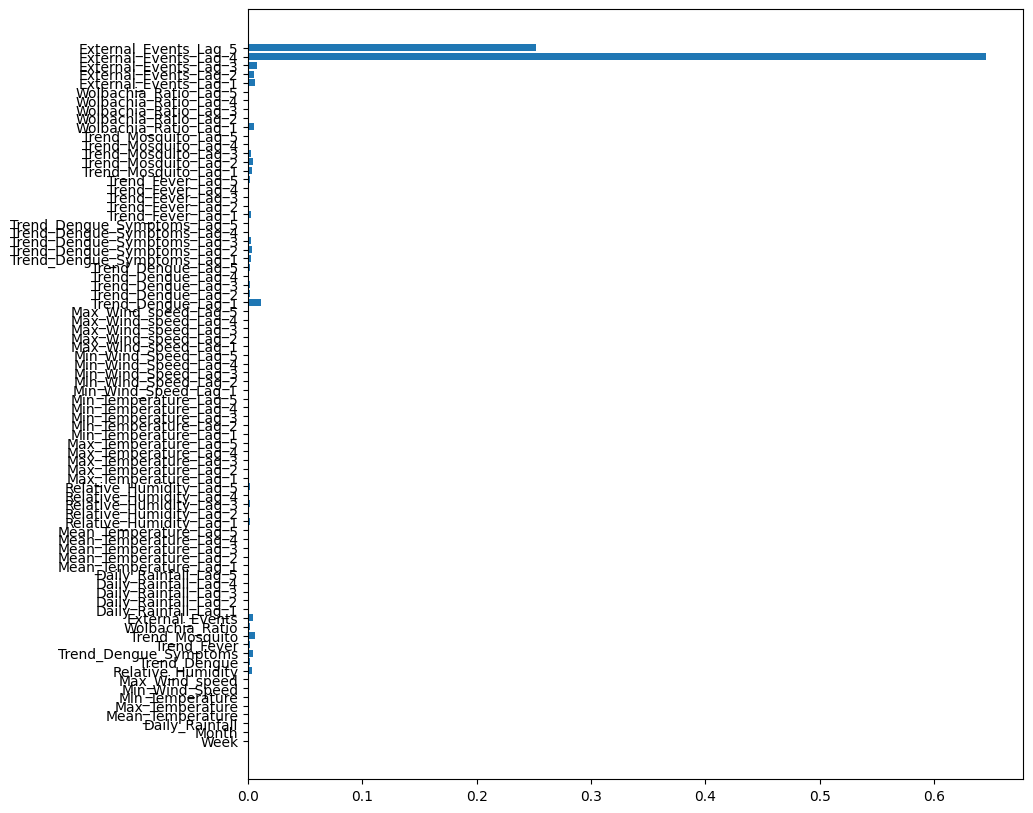

In [28]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.barh(X_train.columns,model.feature_importances_)

### Drop search trend features

While Google seach trends appear to be a powerful predictor of dengue cases, providing good warning signs of imminent Dengue clusters, it may have high correlation with other features, eclipsing the effects of weather conditions which are _casuing_ dengue occurence. Here, we drop search trend results from teh features for a quick assessment.

In [29]:
# Add external events
df_xgb = df_raw.copy()

# Drop search trends
df_xgb.drop(columns=['Trend_Dengue', 'Trend_Dengue_Symptoms','Trend_Fever', 'Trend_Mosquito',],inplace=True)

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed','Wolbachia_Ratio','External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)
df_xgb.head()

# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=42)

Root mean Squared Error: 110.72106085126563


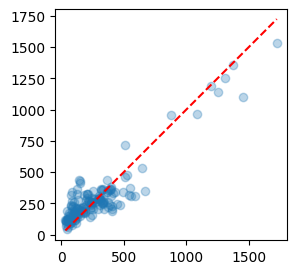

In [30]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean Squared Error: {rmse}")

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_test,y_pred,alpha=0.3)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
ax.axis('equal');

As expected, the accuracy of the model has fallen. Furthermore, the feature importance plot below continues to show the limited impact of Wolbachia efforts.

<BarContainer object of 56 artists>

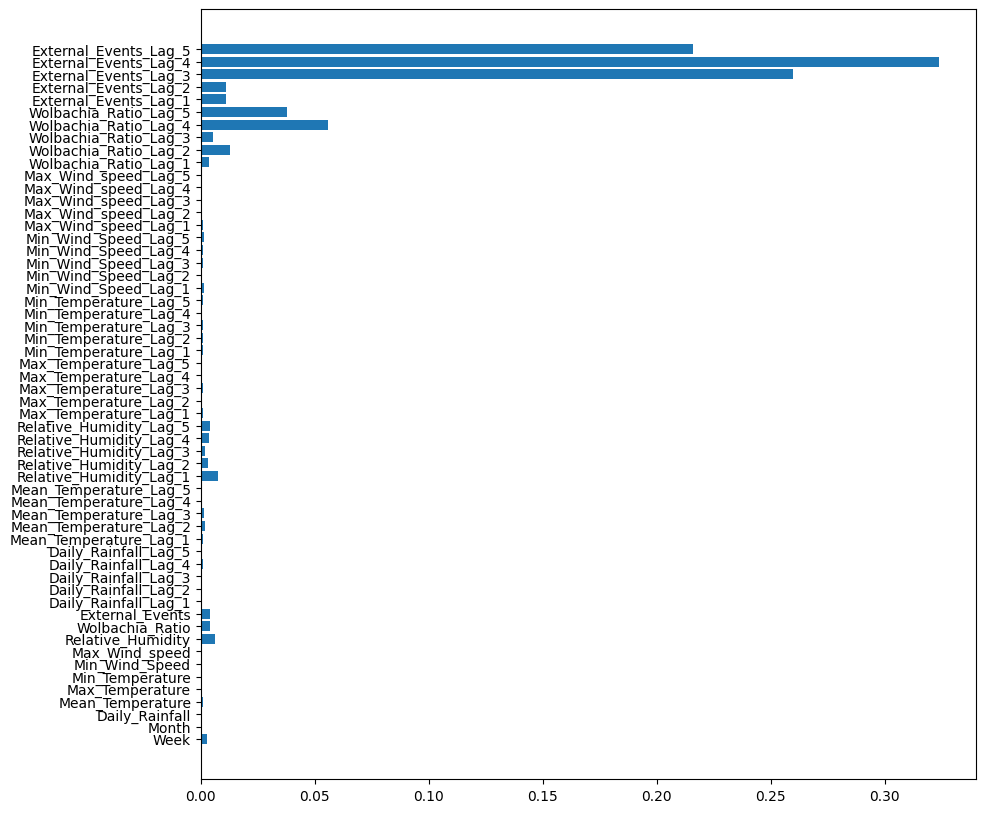

In [31]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.barh(X_train.columns,model.feature_importances_)

### Add lagged labels

For time series data, past data are heavily correlated with current values. This means that past dengue counts will be related to current dengue counts. Here, we add the number of past dengue cases. Search trend features are also included.

In [32]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = range(1, 6)
for lag in lags:
    df_xgb[f'Dengue_Count_Lag_{lag}'] = df_xgb['Dengue_Count'].shift(lag)    


# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=42)

Root mean Squared Error: 50.14892077494558


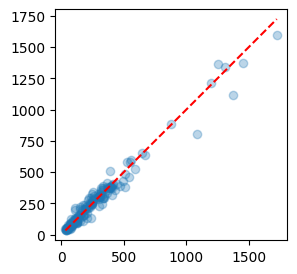

In [33]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean Squared Error: {rmse}")

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_test,y_pred,alpha=0.3)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
ax.axis('equal');

As shown, the presence of lagged labels drastically improves the prediction performance of the model and quickly dwarves the effects of the other features, as shown in the feature importance plot below.

<BarContainer object of 85 artists>

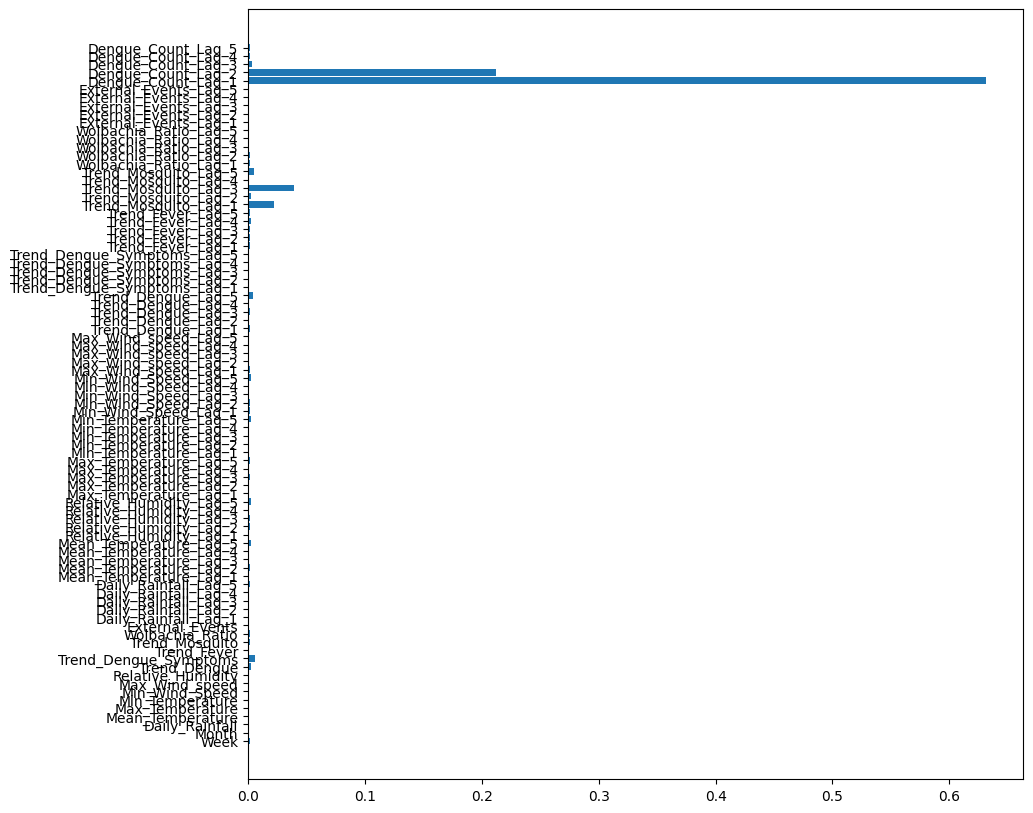

In [34]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.barh(X_train.columns,model.feature_importances_)

### Multiple time period prediction

In time series forecasting, it is often important to make predictions for multiple future time points rather than just one. When using models like XGBoost which are not natively built such prediction approaches, we need to perform predictions sequentially. First, we write a function to predict perform this sequential prediction.

In [35]:
from typing import Dict

def get_sequential_predictions(model, X,
                               dict_label_lags: Dict[int, str]):
    '''
    Get predictions using newly predicted labels as lagged labels.
    model: Model with predict method
    X: Features
    dict_label_lags: Dictionary with key as lagged label number, and value as column name of lagged label.
    '''

    X_pred = X.copy()

    label_lags = list(dict_label_lags.keys())                                          # Lagged label names
    lag_label_col_names = list(dict_label_lags.values())                                                 # Lag values for labels
    
    lag_label_col_locs = [X_pred.columns.get_loc(col) for col in lag_label_col_names]           # Integer index locations (use with iloc) of lagged labels

    pred_val = np.zeros(X_pred.shape[0])                                                        # Initialize predicted value array

    for i in range(X_pred.shape[0]):
        pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
        for k,j in enumerate(label_lags):                                                       # Add predicted value to X_val as lagged labels for subsequent rows
            try:
                X_pred.iloc[i+j,lag_label_col_locs[k]] = pred_val[i]
            except:
                continue
            
    pred_val = np.round(pred_val)                                                               # Round numbers to integers
    pred_val = np.clip(pred_val, 0, 10000000)                                                   # Clip numbers to keep positive and prevent extreme values
    
    return pred_val

We try a quick prediction using a rough xgboost model to see the effect of lagged labels

In [36]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = range(1, 6)
for lag in lags:
    df_xgb[f'Dengue_Count_Lag_{lag}'] = df_xgb['Dengue_Count'].shift(lag)    

# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# To train and test on only years between 2012 and 2018 here
df_xgb = df_xgb[df_xgb.Year<2019]

# Create features and labels
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Manually extracting two months (8 weeks) worth of data for prediction as test set
pred_weeks = 30                                     # USER INPUT: Length of period for prediction in weeks
pred_start = {'Year':2014, 'Week':20}               # USER INPUT: Start of prediction period

ind_pred = (df_xgb['Year'] == pred_start['Year']) & \
    (df_xgb['Week'] == pred_start['Week'])          # Boolean identifying index of prediction start week
ind_pred = df_xgb[ind_pred].index[0]                # Index of prediction start week
ind_pred = np.arange(ind_pred, ind_pred+pred_weeks) # Indices of prediction period

# Manually extracting train test sets
X_test = df_features.loc[ind_pred]
y_test = df_label.loc[ind_pred]
X_train = df_features.drop(ind_pred)
y_train = df_label.drop(ind_pred)

/tmp/ipykernel_344278/3943401478.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
/tmp/ipykernel_344278/3943401478.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
/tmp/ipykernel_344278/3943401478.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract

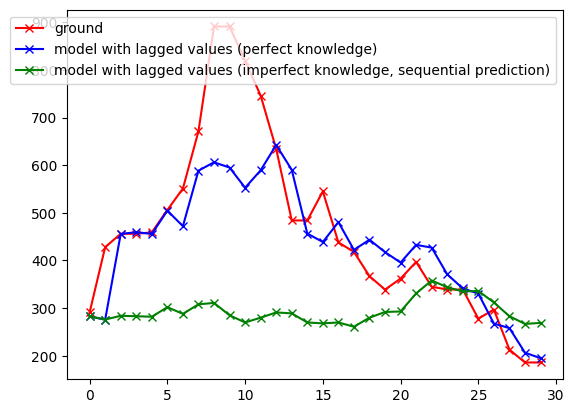

In [37]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

pred1 = model.predict(X_test) # Predict assuming perfect knowledge of past labels
pred2 = get_sequential_predictions(model, X_test, dict_label_lags={1:'Dengue_Count_Lag_1',
                                                                   2:'Dengue_Count_Lag_2',
                                                                   3:'Dengue_Count_Lag_3',
                                                                   4:'Dengue_Count_Lag_4',
                                                                   5:'Dengue_Count_Lag_5'} ) # Predict later labels using earlier predicted labels earlier in the sequence

plt.plot(y_test.reset_index(drop=True),'rx-',label='ground')
plt.plot(pred1,'bx-',label='model with lagged values (perfect knowledge)')
plt.plot(pred2,'gx-',label='model with lagged values (imperfect knowledge, sequential prediction)')
plt.legend()

As shown, using lagged labels is a double edged sword. When we have perfect knowledge of label (i.e. dengue count) values, the prediction is good (blue). However, when making a prediction three weeks into the future, we need good dengue counts from weeks 1 and 2, which we cannot know before hand. The green curve shows this sequential prediction, using _predicted_ dengue counts from weeks 1 and 2 to predict the value in week 3. As shown by the green curve, the prediction can be quite bad, as a wrong prediction early in the sequence can rapidly lead to bad results later.

For comparison, the prediction using a model without any lagged labels is shown below.

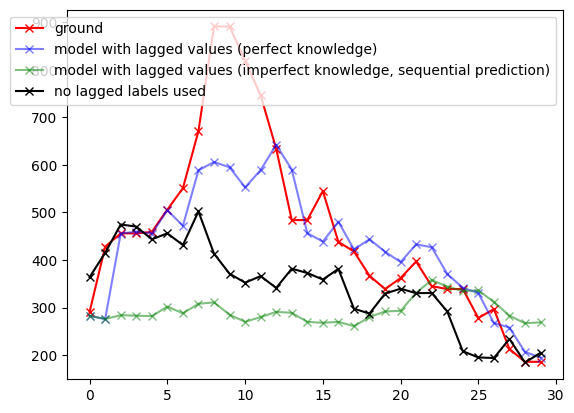

In [38]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

# To train and test on only years between 2012 and 2018
df_xgb = df_xgb[df_xgb.Year<2019]

# Create features and labels
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Manually extracting two months (8 weeks) worth of data for prediction as test set
pred_weeks = 30                                     # USER INPUT: Length of period for prediction in weeks
pred_start = {'Year':2014, 'Week':20}               # USER INPUT: Start of prediction period

ind_pred = (df_xgb['Year'] == pred_start['Year']) & \
    (df_xgb['Week'] == pred_start['Week'])          # Boolean identifying index of prediction start week
ind_pred = df_xgb[ind_pred].index[0]                # Index of prediction start week
ind_pred = np.arange(ind_pred, ind_pred+pred_weeks) # Indices of prediction period

# Manually extracting train test sets
X_test = df_features.loc[ind_pred]
y_test = df_label.loc[ind_pred]
X_train = df_features.drop(ind_pred)
y_train = df_label.drop(ind_pred)

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

pred_no_lag = model.predict(X_test) # Predict without lagged label values

plt.plot(y_test.reset_index(drop=True),'rx-',label='ground')
plt.plot(pred1,'bx-',label='model with lagged values (perfect knowledge)',alpha=0.5)
plt.plot(pred2,'gx-',label='model with lagged values (imperfect knowledge, sequential prediction)',alpha=0.5)
plt.plot(pred_no_lag,'kx-',label='no lagged labels used')
plt.legend()

The new model without any lagged label values (black) appears to outperform the one with imperfect knowledge of lagged values (green), but is inferior to the one with perfect knowledge (blue).

The selection of actual label lags to use is important. Below we try using label lags of 3 and 4 only, which appears to be superior, at least in the early periods.

/tmp/ipykernel_344278/3943401478.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
/tmp/ipykernel_344278/3943401478.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
/tmp/ipykernel_344278/3943401478.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract

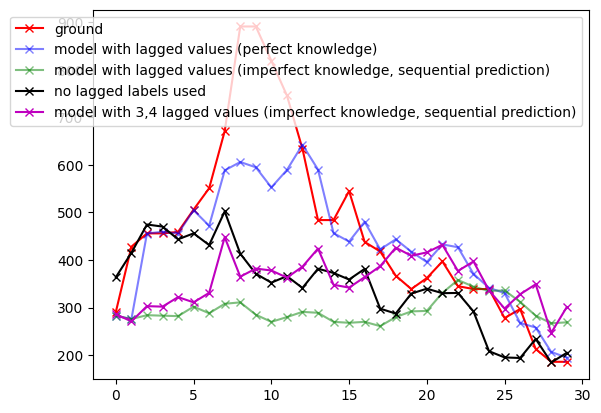

In [39]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']

for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = np.array([3,4])
for lag in label_lags:
    df_xgb[f'Dengue_Count_Lag_{lag}'] = df_xgb['Dengue_Count'].shift(lag)    

# To train and test on only years between 2012 and 2018
df_xgb = df_xgb[df_xgb.Year<2019]

# Create features and labels
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Manually extracting two months (8 weeks) worth of data for prediction as test set
pred_weeks = 30                                     # USER INPUT: Length of period for prediction in weeks
pred_start = {'Year':2014, 'Week':20}               # USER INPUT: Start of prediction period

ind_pred = (df_xgb['Year'] == pred_start['Year']) & \
    (df_xgb['Week'] == pred_start['Week'])          # Boolean identifying index of prediction start week
ind_pred = df_xgb[ind_pred].index[0]                # Index of prediction start week
ind_pred = np.arange(ind_pred, ind_pred+pred_weeks) # Indices of prediction period

# Manually extracting train test sets
X_test = df_features.loc[ind_pred]
y_test = df_label.loc[ind_pred]
X_train = df_features.drop(ind_pred)
y_train = df_label.drop(ind_pred)

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

pred_34lags = get_sequential_predictions(model, X_test, dict_label_lags={3:'Dengue_Count_Lag_3',
                                                                   4:'Dengue_Count_Lag_4'} ) # Predict later labels using earlier predicted labels earlier in the sequence

plt.plot(y_test.reset_index(drop=True),'rx-',label='ground')
plt.plot(pred1,'bx-',label='model with lagged values (perfect knowledge)',alpha=0.5)
plt.plot(pred2,'gx-',label='model with lagged values (imperfect knowledge, sequential prediction)',alpha=0.5)
plt.plot(pred_no_lag,'kx-',label='no lagged labels used')
plt.plot(pred_34lags,'mx-',label='model with 3,4 lagged values (imperfect knowledge, sequential prediction)')
plt.legend()